# Importing packages

In [1]:
from utils.model_summary_functions import feature_importance, metrics, summary_plot,multivariate_importance
from utils.plotting_functions import dual_heat_map

c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import load
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LassoLarsCV, LassoCV, Lasso

import xgboost as xgb
import eli5
from eli5.sklearn import PermutationImportance

from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import feature_importances

In [3]:
np.random.seed(0)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 10),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})


# Importing dataset after EDA

In [7]:
df = pd.read_csv("Processed_data/FRA3-FRA6_cleaned.csv.zip") # Dataset from the notebook "preprocessing"
df

,Distance,SS_Z_TR,SS_Z_LL,SS_Z_TL,SS_Z_LR,TA_X,TA_Y,TA_Z,UA_Z_LR,UA_Z_LL,UA_Z_TR,UA_Z_TL,Irr_Z_RR
0,25.0472,0.000414,0.000265,0.000098,-0.000025,0.000003,-0.000055,0.000002,-0.000004,0.000047,0.000003,-0.000002,-0.002830
1,25.1552,0.000443,0.000308,0.000110,-0.000030,0.000003,-0.000054,0.000004,0.000001,0.000050,0.000003,-0.000002,-0.002450
2,25.2632,0.000471,0.000350,0.000123,-0.000035,0.000004,-0.000053,0.000006,0.000007,0.000053,0.000002,-0.000002,-0.001960
3,25.3712,0.000500,0.000393,0.000135,-0.000041,0.000004,-0.000051,0.000007,0.000013,0.000057,0.000002,-0.000002,-0.001350
4,25.4792,0.000529,0.000435,0.000147,-0.000046,0.000004,-0.000050,0.000009,0.000019,0.000060,0.000002,-0.000002,-0.000653
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68150,7406.5210,-0.111903,-0.231038,0.133286,0.050300,0.001834,-0.017724,0.000079,0.004336,0.001357,0.027580,-0.002892,0.048600
68151,7406.6290,-0.113222,-0.225703,0.140285,0.042200,0.001846,-0.017451,-0.000082,0.003567,0.000598,0.025054,-0.000514,0.051100
68152,7406.7380,-0.114092,-0.220937,0.148758,0.034700,0.001823,-0.017368,-0.000321,0.002644,-0.000098,0.023842,0.002592,0.053500
68153,7406.8460,-0.114961,-0.216170,0.157232,0.027200,0.001800,-0.017286,-0.000559,0.001721,-0.000794,0.022632,0.005697,0.055800


In [8]:
distance = df['Distance']

df_aux = df.drop('Distance',axis=1).copy()
df_aux.columns

Index(['SS_Z_TR', 'SS_Z_LL', 'SS_Z_TL', 'SS_Z_LR', 'TA_X', 'TA_Y', 'TA_Z',
       'UA_Z_LR', 'UA_Z_LL', 'UA_Z_TR', 'UA_Z_TL', 'Irr_Z_RR'],
      dtype='object')

# Baseline models - dataset without feature engineering

In [9]:
def create_scaled_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=0,shuffle=True) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [10]:
# y = df_aux['Vert_irreg_right_rail']
# X = df_aux.drop(['Vert_irreg_right_rail'],axis=1)

y = df_aux['Irr_Z_RR']
X = df_aux.drop(['Irr_Z_RR'],axis=1)

X_scaled_train,X_scaled_test,y_train,y_test = create_scaled_dataset(X,y)

In [11]:
import matplotlib

plt.style.use('default')

plt.rcParams.update({
    'font.size': 22,
    'axes.linewidth': 2,
    'axes.titlesize': 22,
    'axes.edgecolor': 'black',
    'axes.labelsize': 24,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'font.family': 'Arial',
    'legend.fontsize': 16,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})


All models for determining feature importance
[Lasso(random_state=0), RandomForestRegressor(n_jobs=-1, random_state=0), AdaBoostRegressor(random_state=0), GradientBoostingRegressor(random_state=0), ExtraTreesRegressor(n_jobs=-1, random_state=0), XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, seed=123, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)]

Obtaining R2 score for all 6 models


100%|██████████| 6/6 [00:35<00:00,  5.88s/it]
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature 

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%
Obtaining feature importance - 100%
CPU times: total: 2min 11s
Wall time: 35.9 s


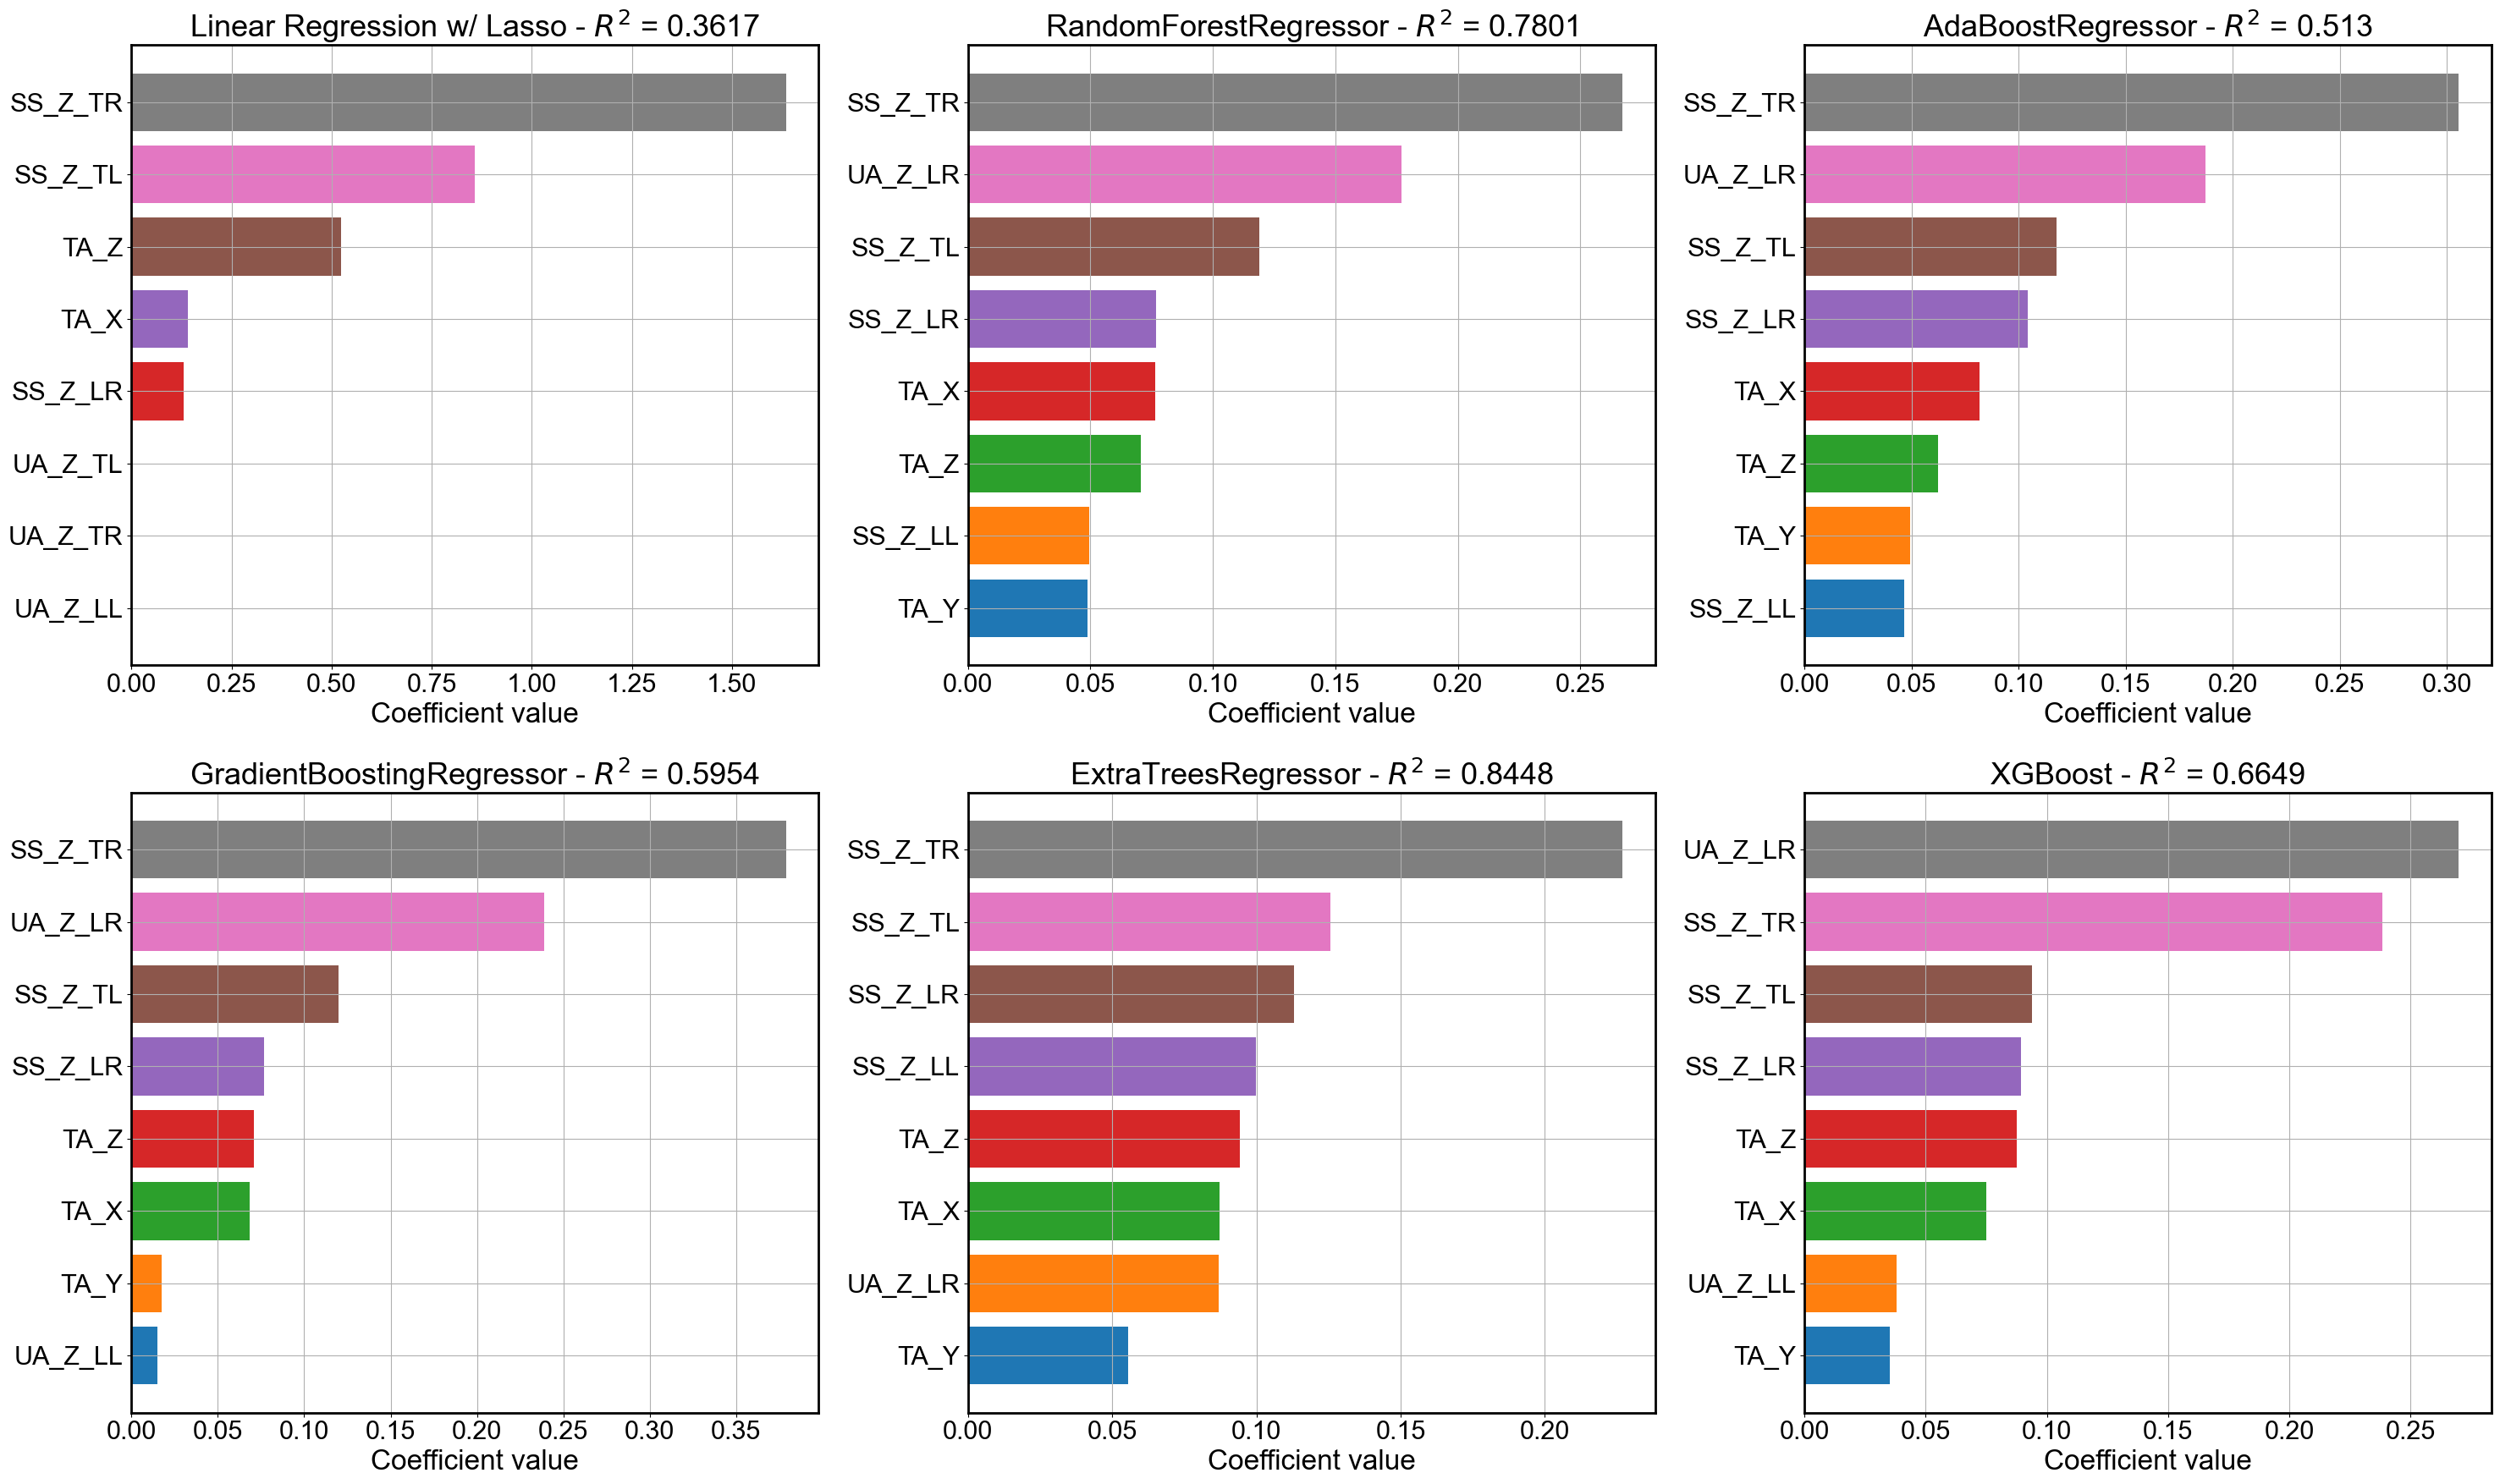

In [12]:
%%time
multi_select = multivariate_importance(X_scaled_train,X_scaled_test,y_train,y_test)     
multi_select.plot(relative=False)

In [13]:
%%time
mdl = ExtraTreesRegressor(n_estimators=100,n_jobs=-1,random_state=0)
mdl.fit(X_scaled_train,y_train)
yhat=mdl.predict(X_scaled_test)
score = metrics(y_test,yhat)

MSE:4.917003285109821 
MAE:1.5974231728465302 
R2:0.8448331406229639
CPU times: total: 22.4 s
Wall time: 2.45 s


c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
c:\Users\arthu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


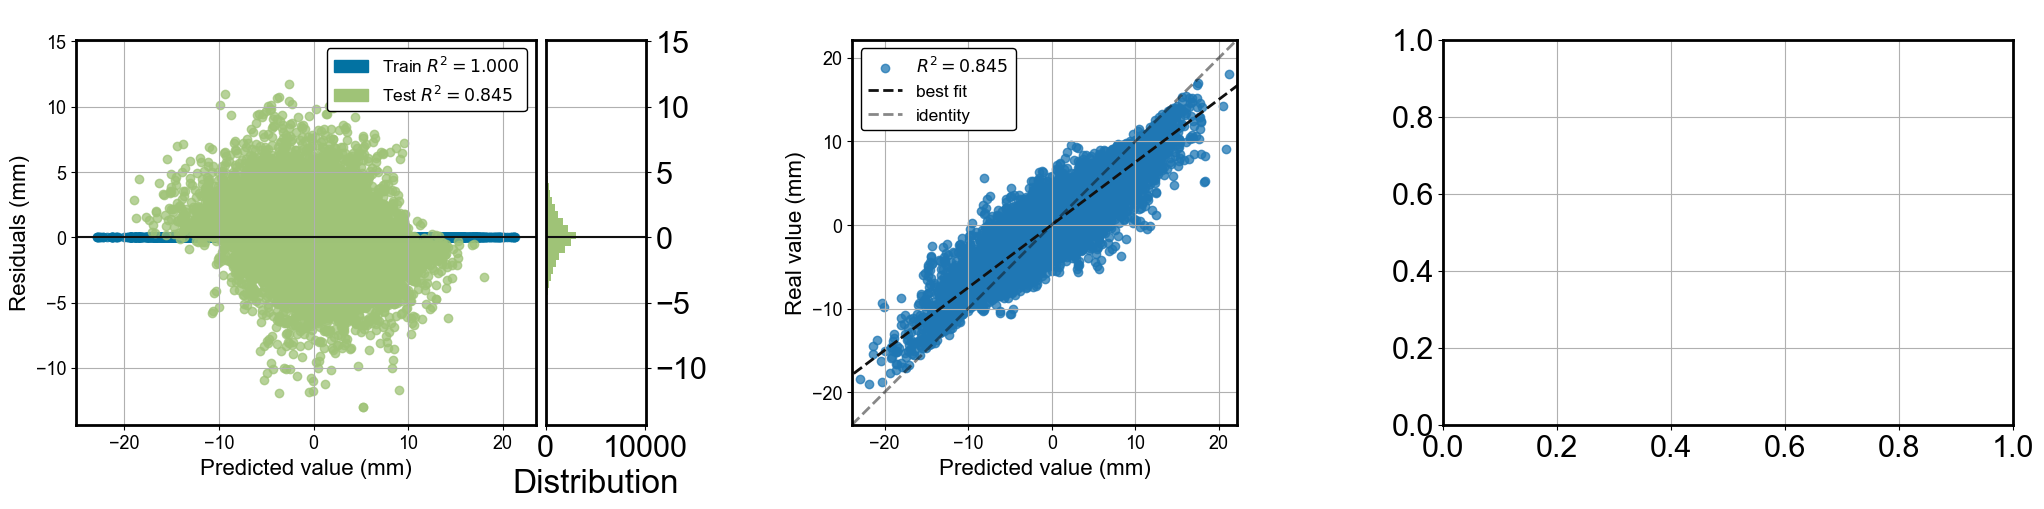

In [14]:
cv = KFold(n_splits=5,shuffle=True)
summary_plot(mdl,X_scaled_train,y_train,X_scaled_test,y_test,cv,train_sizes=np.linspace(0.1,1,5))

# Domain knowledge variables - vehicle movements

Creating variables that represent wagon movements, such as the ones in the figure below

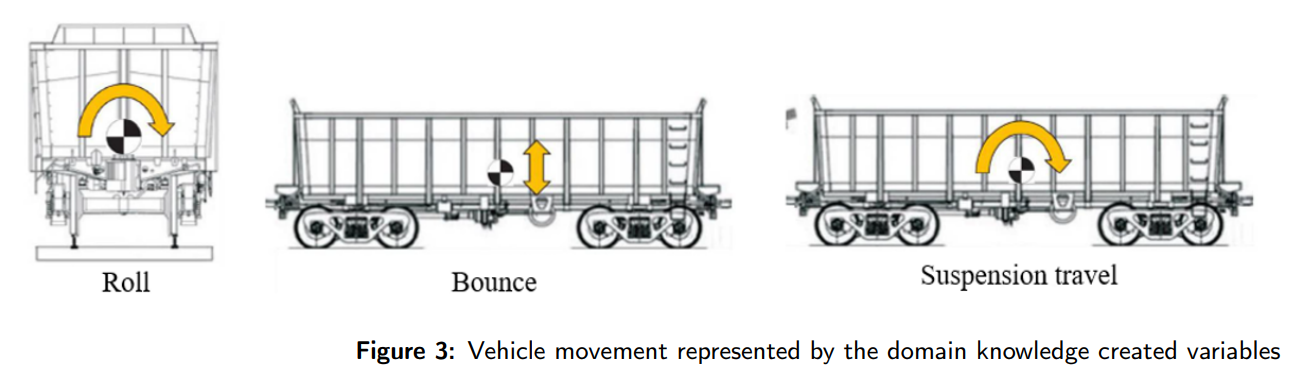

In [15]:
# susp_sensors = ['Trail_right_z_sec_susp', 'Lead_left_z_sec_susp','Trail_left_z_sec_susp', 'Lead_right_z_sec_susp']
# z_accel_columns = ['Lead_z_accel_right_side','Lead_z_accel_left_side', 'Trail_z_accel_right_side','Trail_z_accel_left_side']

In [16]:
susp_sensors = ['SS_Z_TR', 'SS_Z_LL', 'SS_Z_TL', 'SS_Z_LR']
z_accel_columns = ['UA_Z_LR', 'UA_Z_LL', 'UA_Z_TR', 'UA_Z_TL']

In [17]:
df_aux3 = df_aux.copy()
df = df_aux

## Critical acceleration values - accelerometers

In [18]:
logic_vector = df[z_accel_columns].values.max(1) > -1*df[z_accel_columns].values.min(1)

df_aux3['Acc_max'] = df[z_accel_columns].values.min(1) # Initializing the vector
df_aux3['Acc_max'][logic_vector] = df[z_accel_columns][logic_vector].values.max(1) # Overwriting the vector

## Suspension Travel - suspension sensors

In [19]:
# susp_col_right = ['Lead_right_z_sec_susp','Trail_right_z_sec_susp']
# susp_col_left = ['Lead_left_z_sec_susp','Trail_left_z_sec_susp']

susp_col_right = ['SS_Z_LR', 'SS_Z_TR']
susp_col_left = ['SS_Z_LL', 'SS_Z_TL']

logic_vector_left= df[susp_col_left].values.max(1) > -1*df[susp_col_left].values.min(1)
df_aux3['SuspTravel_L'] = df[susp_col_left].values.min(1) 
df_aux3['SuspTravel_L'][logic_vector_left] = df[susp_col_left][logic_vector_left].values.max(1)  # Maximum deflection on the left side


logic_vector_right= df[susp_col_right].values.max(1) > -1*df[susp_col_right].values.min(1)
df_aux3['SuspTravel_R'] = df[susp_col_right].values.min(1) 
df_aux3['SuspTravel_R'][logic_vector_right] = df[susp_col_right][logic_vector_right].values.max(1)  # Maximum deflection on the right side


############ Suspension travel #############
susp_columns = ['SuspTravel_R','SuspTravel_L']

logic_vector= df_aux3[susp_columns].values.max(1) > -1*df_aux3[susp_columns].values.min(1)
df_aux3['SuspTravel'] = df_aux3[susp_columns].values.min(1) 
df_aux3['SuspTravel'][logic_vector] = df_aux3[susp_columns][logic_vector].values.max(
    1)  # Largest value between Susp_travel_left and Susp_travel_right


## Pitch - Accelerometers and suspension sensors

In [20]:
l = 6.39 # Distance between accelerometers, in meters
df_aux3['Pitch_Acc_R'] = (df['UA_Z_LR'] - df['UA_Z_TR'])/l
df_aux3['Pitch_Acc_L'] = (df['UA_Z_LL'] - df['UA_Z_TL'])/l
col = ['Pitch_Acc_R', 'Pitch_Acc_L']

logic_vector = df_aux3[col].values.max(1) > -1*df_aux3[col].values.min(1)
df_aux3['Pitch_Acc'] = df_aux3[col].values.min(1) 
df_aux3['Pitch_Acc'][logic_vector] = df_aux3[col][logic_vector].values.max(1) 

In [21]:
l = l - 0.598*2 # Distance between suspension sensors, in meters
df_aux3['Pitch_Susp_R'] = (df['SS_Z_LR'] - df['SS_Z_TR'])/l
df_aux3['Pitch_Susp_L'] = (df['SS_Z_LL'] - df['SS_Z_TL'])/l 
col = ['Pitch_Susp_R', 'Pitch_Susp_L']

logic_vector = df_aux3[col].values.max(1) > -1*df_aux3[col].values.min(1)
df_aux3['Pitch_Susp'] = df_aux3[col].values.min(1) 
df_aux3['Pitch_Susp'][logic_vector] = df_aux3[col][logic_vector].values.max(1) 

In [22]:
# l = 6.39 # Distance between accelerometers, in meters
# df_aux3['Pitch_right_accel'] = (df['Lead_z_accel_right_side'] - df['Trail_z_accel_right_side'])/l 
# df_aux3['Pitch_left_accel'] = (df['Lead_z_accel_left_side'] - df['Trail_z_accel_left_side'])/l 
# col = ['Pitch_right_accel','Pitch_left_accel']

# logic_vector = df_aux3[col].values.max(1) > -1*df_aux3[col].values.min(1)
# df_aux3['Pitch_accel'] = df_aux3[col].values.min(1) 
# df_aux3['Pitch_accel'][logic_vector] = df_aux3[col][logic_vector].values.max(1) 

In [23]:
# l = l - 0.598*2 # Distance between suspension sensors, in meters
# df_aux3['Pitch_right_susp'] = (df['Lead_right_z_sec_susp'] - df['Trail_right_z_sec_susp'])/l 
# df_aux3['Pitch_left_susp'] = (df['Lead_left_z_sec_susp'] - df['Trail_left_z_sec_susp'])/l 
# col = ['Pitch_right_susp','Pitch_left_susp']

# logic_vector = df_aux3[col].values.max(1) > -1*df_aux3[col].values.min(1)
# df_aux3['Pitch_susp'] = df_aux3[col].values.min(1) 
# df_aux3['Pitch_susp'][logic_vector] = df_aux3[col][logic_vector].values.max(1) 

## Bounce - Accelerometers and suspension sensors

In [24]:
df_aux3['FrontBounce_Susp'] = (df['SS_Z_LL']+df['SS_Z_LR'])/2
df_aux3['BackBounce_Susp'] = (df['SS_Z_TL']+df['SS_Z_TR'])/2

col = ['FrontBounce_Susp', 'BackBounce_Susp']

logic_vector = df_aux3[col].values.max(1) > -1*df_aux3[col].values.min(1)
df_aux3['Bounce_Susp'] = df_aux3[col].values.min(1)  # Initializing the vector
df_aux3['Bounce_Susp'][logic_vector] = df_aux3[col][logic_vector].values.max(1)

In [25]:
df_aux3['FrontBounce_Acc'] = (df['UA_Z_LL']+df['UA_Z_LR'])/2
df_aux3['BackBounce_Acc'] = (df['UA_Z_TL']+df['UA_Z_TR'])/2

col = ['FrontBounce_Acc','BackBounce_Acc']

logic_vector = df_aux3[col].values.max(1) > -1*df_aux3[col].values.min(1)
df_aux3['Bounce_Acc'] = df_aux3[col].values.min(1) # Initializing the vector
df_aux3['Bounce_Acc'][logic_vector] = df_aux3[col][logic_vector].values.max(1) # Overwriting the vector

In [26]:
# df_aux3['Front_Bounce_susp'] = (df['Lead_left_z_sec_susp']+df['Lead_right_z_sec_susp'])/2
# df_aux3['Back_Bounce_susp'] = (df['Trail_left_z_sec_susp']+df['Trail_right_z_sec_susp'])/2

# col = ['Front_Bounce_susp','Back_Bounce_susp']

# logic_vector = df_aux3[col].values.max(1) > -1*df_aux3[col].values.min(1)
# df_aux3['Bounce_susp'] = df_aux3[col].values.min(1) # Initializing the vector
# df_aux3['Bounce_susp'][logic_vector] = df_aux3[col][logic_vector].values.max(1) 

In [27]:
# df_aux3['Front_Bounce_accel'] = (df['Lead_z_accel_left_side']+df['Lead_z_accel_right_side'])/2
# df_aux3['Back_Bounce_accel'] = (df['Trail_z_accel_left_side']+df['Trail_z_accel_right_side'])/2

# col = ['Front_Bounce_accel','Back_Bounce_accel']

# logic_vector = df_aux3[col].values.max(1) > -1*df_aux3[col].values.min(1)
# df_aux3['Bounce_accel'] = df_aux3[col].values.min(1) # Initializing the vector
# df_aux3['Bounce_accel'][logic_vector] = df_aux3[col][logic_vector].values.max(1) # Overwriting the vector

## Roll - Accelerometers and suspension sensors""

In [28]:
w = 1  # Distance between suspension sensors

df_aux3['FrontRoll_Susp'] = (df['SS_Z_LL']-df['SS_Z_LR'])/w
df_aux3['BackRoll_Susp'] = (df['SS_Z_TL']-df['SS_Z_TR'])/w

col = ['FrontRoll_Susp', 'BackRoll_Susp']

logic_vector = df_aux3[col].values.max(1) > -1*df_aux3[col].values.min(1)
df_aux3['Roll_Susp'] = df_aux3[col].values.min(1)  # Initializing the vector
df_aux3['Roll_Susp'][logic_vector] = df_aux3[col][logic_vector].values.max(1)  # Overwriting the vector

In [29]:
w = 1 # Distance between accelerometers

df_aux3['FrontRoll_Acc'] = (df['UA_Z_LL']-df['UA_Z_LR'])/w
df_aux3['BackRoll_Acc'] = (df['UA_Z_TL']-df['UA_Z_TR'])/w

col = ['FrontRoll_Acc','BackRoll_Acc']

logic_vector = df_aux3[col].values.max(1) > -1*df_aux3[col].values.min(1)
df_aux3['Roll_Acc'] = df_aux3[col].values.min(1) # Initializing the vector
df_aux3['Roll_Acc'][logic_vector] = df_aux3[col][logic_vector].values.max(1) # Overwriting the vector

df_aux3

,SS_Z_TR,SS_Z_LL,SS_Z_TL,SS_Z_LR,TA_X,TA_Y,TA_Z,UA_Z_LR,UA_Z_LL,UA_Z_TR,...,Bounce_Susp,FrontBounce_Acc,BackBounce_Acc,Bounce_Acc,FrontRoll_Susp,BackRoll_Susp,Roll_Susp,FrontRoll_Acc,BackRoll_Acc,Roll_Acc
0,0.000414,0.000265,0.000098,-0.000025,0.000003,-0.000055,0.000002,-0.000004,0.000047,0.000003,...,0.000256,0.000022,5.000000e-07,0.000022,0.000290,-0.000316,-0.000316,0.000051,-0.000005,0.000051
1,0.000443,0.000308,0.000110,-0.000030,0.000003,-0.000054,0.000004,0.000001,0.000050,0.000003,...,0.000276,0.000026,5.000000e-07,0.000026,0.000338,-0.000333,0.000338,0.000049,-0.000005,0.000049
2,0.000471,0.000350,0.000123,-0.000035,0.000004,-0.000053,0.000006,0.000007,0.000053,0.000002,...,0.000297,0.000030,0.000000e+00,0.000030,0.000385,-0.000348,0.000385,0.000046,-0.000004,0.000046
3,0.000500,0.000393,0.000135,-0.000041,0.000004,-0.000051,0.000007,0.000013,0.000057,0.000002,...,0.000318,0.000035,0.000000e+00,0.000035,0.000434,-0.000365,0.000434,0.000044,-0.000004,0.000044
4,0.000529,0.000435,0.000147,-0.000046,0.000004,-0.000050,0.000009,0.000019,0.000060,0.000002,...,0.000338,0.000040,0.000000e+00,0.000040,0.000481,-0.000382,0.000481,0.000041,-0.000004,0.000041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68150,-0.111903,-0.231038,0.133286,0.050300,0.001834,-0.017724,0.000079,0.004336,0.001357,0.027580,...,-0.090369,0.002847,1.234400e-02,0.012344,-0.281338,0.245189,-0.281338,-0.002979,-0.030472,-0.030472
68151,-0.113222,-0.225703,0.140285,0.042200,0.001846,-0.017451,-0.000082,0.003567,0.000598,0.025054,...,-0.091751,0.002083,1.227000e-02,0.012270,-0.267903,0.253507,-0.267903,-0.002969,-0.025568,-0.025568
68152,-0.114092,-0.220937,0.148758,0.034700,0.001823,-0.017368,-0.000321,0.002644,-0.000098,0.023842,...,-0.093118,0.001273,1.321700e-02,0.013217,-0.255637,0.262850,0.262850,-0.002742,-0.021250,-0.021250
68153,-0.114961,-0.216170,0.157232,0.027200,0.001800,-0.017286,-0.000559,0.001721,-0.000794,0.022632,...,-0.094485,0.000464,1.416450e-02,0.014164,-0.243370,0.272193,0.272193,-0.002515,-0.016935,-0.016935


In [30]:
df_aux3.columns

Index(['SS_Z_TR', 'SS_Z_LL', 'SS_Z_TL', 'SS_Z_LR', 'TA_X', 'TA_Y', 'TA_Z',
       'UA_Z_LR', 'UA_Z_LL', 'UA_Z_TR', 'UA_Z_TL', 'Irr_Z_RR', 'Acc_max',
       'SuspTravel_L', 'SuspTravel_R', 'SuspTravel', 'Pitch_Acc_R',
       'Pitch_Acc_L', 'Pitch_Acc', 'Pitch_Susp_R', 'Pitch_Susp_L',
       'Pitch_Susp', 'FrontBounce_Susp', 'BackBounce_Susp', 'Bounce_Susp',
       'FrontBounce_Acc', 'BackBounce_Acc', 'Bounce_Acc', 'FrontRoll_Susp',
       'BackRoll_Susp', 'Roll_Susp', 'FrontRoll_Acc', 'BackRoll_Acc',
       'Roll_Acc'],
      dtype='object')

In [31]:
# w = 1 # Distance between suspension sensors

# df_aux3['Front_Roll_susp'] = (df['Lead_left_z_sec_susp']-df['Lead_right_z_sec_susp'])/w
# df_aux3['Back_Roll_susp'] = (df['Trail_left_z_sec_susp']-df['Trail_right_z_sec_susp'])/w

# col = ['Front_Roll_susp','Back_Roll_susp']

# logic_vector = df_aux3[col].values.max(1) > -1*df_aux3[col].values.min(1)
# df_aux3['Roll_susp'] = df_aux3[col].values.min(1) # Initializing the vector
# df_aux3['Roll_susp'][logic_vector] = df_aux3[col][logic_vector].values.max(1) # Overwriting the vector

In [32]:
# w = 1 # Distance between accelerometers

# df_aux3['Front_Roll_accel'] = (df['Lead_z_accel_left_side']-df['Lead_z_accel_right_side'])/w
# df_aux3['Back_Roll_accel'] = (df['Trail_z_accel_left_side']-df['Trail_z_accel_right_side'])/w

# col = ['Front_Roll_accel','Back_Roll_accel']

# logic_vector = df_aux3[col].values.max(1) > -1*df_aux3[col].values.min(1)
# df_aux3['Roll_accel'] = df_aux3[col].values.min(1) # Initializing the vector
# df_aux3['Roll_accel'][logic_vector] = df_aux3[col][logic_vector].values.max(1) # Overwriting the vector

# df_aux3

## Feature importance

In [33]:
# y = df_aux3['Vert_irreg_right_rail']
# X = df_aux3.drop(['Vert_irreg_right_rail'],axis=1)
# X_scaled_train,X_scaled_test,y_train,y_test = create_scaled_dataset(X,y)

# multi_select = multivariate_importance(X_scaled_train,X_scaled_test,y_train,y_test)
# multi_select.plot(relative=False)

In [34]:
# rff = ExtraTreesRegressor(n_estimators = 100,n_jobs = -1,random_state = 0)
# rff.fit(X_scaled_train, y_train)
# metrics(y_test,rff.predict(X_scaled_test))

In [35]:
# summary_plot(rff, X_scaled_train, y_train, X_scaled_test,y_test, cv, train_sizes=np.linspace(0.1, 1, 5))

Forest models perform slighty worse while the other models perform slightly better. We will keep these domain knowledge variables

# Domain knowledge - integrating accelerometer signal to obtain position

In [36]:
# # Columns to integrate
# cols_accel = ['Lead_z_accel_right_side','Lead_z_accel_left_side','Trail_z_accel_right_side','Trail_z_accel_left_side']

# # Columns that will be created
# cols_vel = ['Lead_z_vel_right_side','Lead_z_vel_left_side','Trail_z_vel_right_side','Trail_z_vel_left_side']
# cols_pos = ['Lead_z_pos_right_side','Lead_z_pos_left_side','Trail_z_pos_right_side','Trail_z_pos_left_side']

In [37]:
# Columns to integrate
cols_accel = ['UA_Z_LR', 'UA_Z_LL', 'UA_Z_TR', 'UA_Z_TL']
# Columns that will be created
cols_vel = ['UA_Z_LR_Vel', 'UA_Z_LL_Vel', 'UA_Z_TR_Vel', 'UA_Z_TL_Vel']
cols_pos = ['UA_Z_LR_Pos', 'UA_Z_LL_Pos', 'UA_Z_TR_Pos', 'UA_Z_TL_Pos']

In [38]:
distance[1]-distance[0]

0.10800000000000054

In [39]:
# Initializing variable
df_aux3[cols_vel] = 0
df_aux3[cols_pos] = 0

In [40]:
from scipy.integrate import simps

# Trapezoidal integration

for idx, col in enumerate(cols_vel):
    for i in tqdm(range(df_aux3.shape[0]-1)):

        df_aux3.loc[i, cols_vel[idx]] = simps(df_aux3.loc[i:i+1, cols_accel[idx]], dx=0.108)  # distance[i:i+2]

100%|██████████| 68154/68154 [00:13<00:00, 5001.96it/s]


In [41]:
for idx, col in enumerate(cols_vel):
    for i in tqdm(range(df_aux3.shape[0]-1)):

        df_aux3.loc[i, cols_pos[idx]] = simps(df_aux3.loc[i:i+1, cols_vel[idx]], dx=0.108)

100%|██████████| 68154/68154 [00:14<00:00, 4780.88it/s]


<AxesSubplot:>

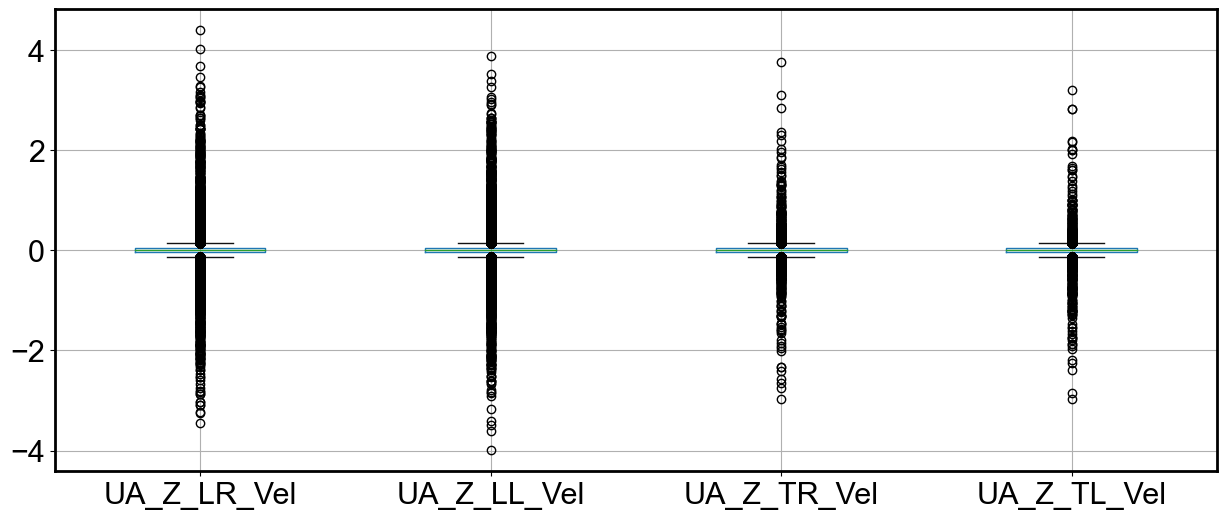

In [42]:
df_aux3.loc[:, cols_vel[:]].boxplot()

<AxesSubplot:>

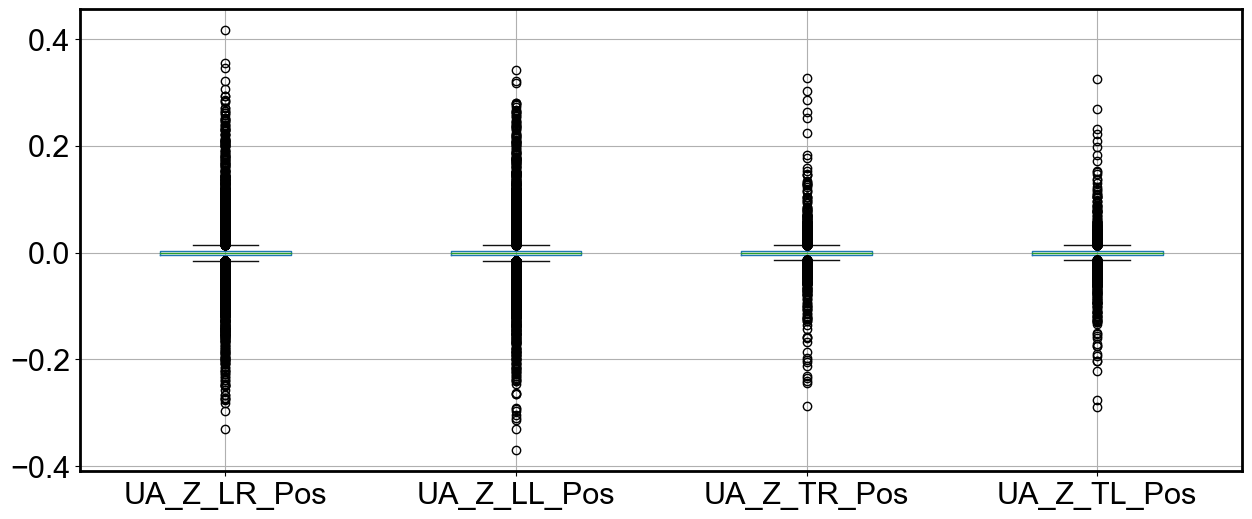

In [43]:
df_aux3.loc[:, cols_pos[:]].boxplot()

In [44]:
# df2 = df_aux3[['Vert_irreg_right_rail',
#                'Lead_z_pos_right_side', 'Lead_z_pos_left_side',
#                 'Trail_z_pos_right_side', 'Trail_z_pos_left_side']]

# g = sns.PairGrid(df2, corner=True, height=4, aspect=1)
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot, s=3, alpha=0.6)
# g.add_legend()
# plt.tight_layout()

In [45]:
# y = df_aux3['Vert_irreg_right_rail']
# X = df_aux3.drop(['Vert_irreg_right_rail'],axis=1)
# X_scaled_train,X_scaled_test,y_train,y_test = create_scaled_dataset(X,y)

# multi_select = multivariate_importance(X_scaled_train, X_scaled_test, y_train, y_test)
# multi_select.plot(relative=False)

In [46]:
# dual_heat_map(df_aux3, dual=False, figsize=(30, 40))

In [47]:
# rff = ExtraTreesRegressor(n_estimators = 100,n_jobs = -1,random_state = 0)

# rff.fit(X_scaled_train, y_train)
# metrics(y_test,rff.predict(X_scaled_test))

In [48]:
#summary_plot(rff, X_scaled_train, y_train, X_scaled_test,y_test, cv, train_sizes=np.linspace(0.1, 1, 5))

# Exporting dataset

In [49]:
df_aux3


,SS_Z_TR,SS_Z_LL,SS_Z_TL,SS_Z_LR,TA_X,TA_Y,TA_Z,UA_Z_LR,UA_Z_LL,UA_Z_TR,...,BackRoll_Acc,Roll_Acc,UA_Z_LR_Vel,UA_Z_LL_Vel,UA_Z_TR_Vel,UA_Z_TL_Vel,UA_Z_LR_Pos,UA_Z_LL_Pos,UA_Z_TR_Pos,UA_Z_TL_Pos
0,0.000414,0.000265,0.000098,-0.000025,0.000003,-0.000055,0.000002,-0.000004,0.000047,0.000003,...,-0.000005,0.000051,-1.620000e-07,0.000005,3.240000e-07,-2.160000e-07,1.458000e-08,5.832000e-07,3.207600e-08,-2.332800e-08
1,0.000443,0.000308,0.000110,-0.000030,0.000003,-0.000054,0.000004,0.000001,0.000050,0.000003,...,-0.000005,0.000049,4.320000e-07,0.000006,2.700000e-07,-2.160000e-07,8.164800e-08,6.211080e-07,2.624400e-08,-2.332800e-08
2,0.000471,0.000350,0.000123,-0.000035,0.000004,-0.000053,0.000006,0.000007,0.000053,0.000002,...,-0.000004,0.000046,1.080000e-06,0.000006,2.160000e-07,-2.160000e-07,1.516320e-07,6.619320e-07,2.332800e-08,-2.332800e-08
3,0.000500,0.000393,0.000135,-0.000041,0.000004,-0.000051,0.000007,0.000013,0.000057,0.000002,...,-0.000004,0.000044,1.728000e-06,0.000006,2.160000e-07,-2.160000e-07,2.157840e-07,6.998400e-07,2.332800e-08,-2.332800e-08
4,0.000529,0.000435,0.000147,-0.000046,0.000004,-0.000050,0.000009,0.000019,0.000060,0.000002,...,-0.000004,0.000041,2.268000e-06,0.000007,2.160000e-07,-2.160000e-07,2.741040e-07,7.319160e-07,2.332800e-08,-2.332800e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68150,-0.111903,-0.231038,0.133286,0.050300,0.001834,-0.017724,0.000079,0.004336,0.001357,0.027580,...,-0.030472,-0.030472,4.267620e-04,0.000106,2.842236e-03,-1.839240e-04,4.115642e-05,7.158780e-06,2.960615e-04,-3.872448e-06
68151,-0.113222,-0.225703,0.140285,0.042200,0.001846,-0.017451,-0.000082,0.003567,0.000598,0.025054,...,-0.025568,-0.025568,3.353940e-04,0.000027,2.640384e-03,1.122120e-04,3.083962e-05,-1.143072e-06,2.780989e-04,3.023017e-05
68152,-0.114092,-0.220937,0.148758,0.034700,0.001823,-0.017368,-0.000321,0.002644,-0.000098,0.023842,...,-0.021250,-0.021250,2.357100e-04,-0.000048,2.509596e-03,4.476060e-04,1.988712e-05,-9.509076e-06,2.590691e-04,6.650230e-05
68153,-0.114961,-0.216170,0.157232,0.027200,0.001800,-0.017286,-0.000559,0.001721,-0.000794,0.022632,...,-0.016935,-0.016935,1.325700e-04,-0.000128,2.287980e-03,7.839180e-04,7.158780e-06,-6.908004e-06,1.235509e-04,4.233157e-05


In [50]:
df_aux3.to_csv('Processed_data/FRA3-FRA6_cleaned_domain_knowledge.csv.zip',index=False,compression="zip")

# Test - integration time domain function

In [ ]:
# The analytical integral should be equal to one - https://www.youtube.com/watch?v=mCPWtXVyzFg
# x = np.linspace(0,np.pi/2,100)
# signal = x*np.sin(x)
# plt.plot(x,signal)

In [ ]:
# from scipy.integrate import simps

# # Trapezoidal integration

# dist = x[1]-x[0]
# vel = signal*0
# pos = vel*0

# for i in tqdm(range(len(signal)-1)):
#     vel[i+1] = simps(signal[i:i+2], x[i:i+2])

# for i in tqdm(range(len(signal)-1)):
#     pos[i+1] = simps(vel[i:i+2], x[i:i+2])

In [ ]:
# vel.sum()

In [ ]:
# fig, ax = plt.subplots(3, 1, figsize=(30, 16), sharex=True)

# ax[0].set_title("Original Signal: ")
# ax[0].plot(x, signal)
# ax[1].set_title("Integrated Signal: ")
# ax[1].plot(x, vel)
# ax[2].set_title("Double integrated Signal: ")
# ax[2].plot(x,pos)

# ax[2].set_xlabel('Time(s)')
# plt.show()